# Protein Secondary Structure
## Author: Eren ERİŞ
Dataset: https://www.kaggle.com/datasets/alfrandom/protein-secondary-structure

Desription : 

In [22]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.layers import Input
from keras.models import Model
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional

from sklearn.model_selection import train_test_split
from keras.metrics import categorical_accuracy
from keras import backend  as K
import tensorflow as tf

<Axes: >

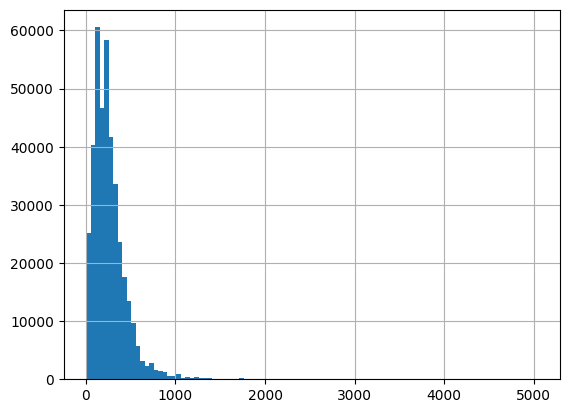

In [23]:
df = pd.read_csv('/kaggle/input/protein-secondary-structure/2018-06-06-ss.cleaned.csv')
df.len.hist(bins=100)


In [5]:
df.head()

,pdb_id,chain_code,seq,sst8,sst3,len,has_nonstd_aa
0,1A30,C,EDL,CBC,CEC,3,False
1,1B05,B,KCK,CBC,CEC,3,False
2,1B0H,B,KAK,CBC,CEC,3,False
3,1B1H,B,KFK,CBC,CEC,3,False
4,1B2H,B,KAK,CBC,CEC,3,False


In [6]:
df.shape

(393732, 7)

In [13]:



def seq2ngrams(seqs, n=3):
    ngrams = []
    for seq in seqs:
        seq_ngrams = [seq[i:i+n] for i in range(len(seq))]
        ngrams.append(seq_ngrams)
    return ngrams

maxlen_seq = 128
input_seqs, target_seqs = df[['seq', 'sst3']][(df.len <= maxlen_seq) & (~df.has_nonstd_aa)].values.T
input_grams = seq2ngrams(input_seqs)
print(len(input_seqs))

88751


In [15]:
tokenizer_encoder = Tokenizer()
tokenizer_encoder.fit_on_texts(input_grams)
input_data = tokenizer_encoder.texts_to_sequences(input_grams)
input_data = sequence.pad_sequences(input_data, maxlen=maxlen_seq, padding='post')

tokenizer_decoder = Tokenizer(char_level=True)
tokenizer_decoder.fit_on_texts(target_seqs)
target_data = tokenizer_decoder.texts_to_sequences(target_seqs)
target_data = sequence.pad_sequences(target_data, maxlen=maxlen_seq, padding='post')
target_data = to_categorical(target_data)
input_data.shape, target_data.shape

((88751, 128), (88751, 128, 4))

In [21]:


n_words = len(tokenizer_encoder.word_index) + 1
n_tags = len(tokenizer_decoder.word_index) + 1
print(n_words, n_tags)

input = Input(shape=(maxlen_seq,))
x = Embedding(input_dim=n_words, output_dim=128, input_length=maxlen_seq)(input)
x = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.1))(x)
y = TimeDistributed(Dense(n_tags, activation="softmax"))(x)
model = Model(input, y)
model.summary()

8421 4
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 128)          1077888   
                                                                 
 bidirectional (Bidirection  (None, 128, 128)          98816     
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 128, 4)            516       
 ributed)                                                        
                                                                 
Total params: 1177220 (4.49 MB)
Trainable params: 1177220 (4.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
def q3_acc(y_true, y_pred):
    y = tf.argmax(y_true, axis=-1)
    y_ = tf.argmax(y_pred, axis=-1)
    mask = tf.greater(y, 0)
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy", q3_acc])

X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=.4, random_state=0)
seq_train, seq_test, target_train, target_test = train_test_split(input_seqs, target_seqs, test_size=.4, random_state=0)

model.fit(X_train, y_train, batch_size=128, epochs=5, validation_data=(X_test, y_test), verbose=1)

Epoch 1/5
417/417 [==============================] - 161s 372ms/step - loss: 0.5766 - accuracy: 0.7253 - q3_acc: 0.5625 - val_loss: 0.5156 - val_accuracy: 0.7758 - val_q3_acc: 0.6447
Epoch 2/5
417/417 [==============================] - 151s 361ms/step - loss: 0.3713 - accuracy: 0.8460 - q3_acc: 0.7545 - val_loss: 0.3333 - val_accuracy: 0.8656 - val_q3_acc: 0.7870
Epoch 3/5
417/417 [==============================] - 150s 361ms/step - loss: 0.3176 - accuracy: 0.8721 - q3_acc: 0.7962 - val_loss: 0.3086 - val_accuracy: 0.8772 - val_q3_acc: 0.8053
Epoch 4/5
417/417 [==============================] - 149s 358ms/step - loss: 0.2916 - accuracy: 0.8844 - q3_acc: 0.8157 - val_loss: 0.3407 - val_accuracy: 0.8643 - val_q3_acc: 0.7850
Epoch 5/5
417/417 [==============================] - 148s 355ms/step - loss: 0.2735 - accuracy: 0.8922 - q3_acc: 0.8282 - val_loss: 0.3033 - val_accuracy: 0.8803 - val_q3_acc: 0.8103


1/1 [==============================] - 0s 46ms/step
training
---
Input: MGDKPIWEQIGSSFINHYYQLFDNDRTQLGAIYIDASCLTWEGQQFQGKAAIVEKLSSLPFQKIQHSITAQDHQPTPDSCIISMVVGQLKADEDPIMGFHQEFLLKNINDAWVCTNDMFRLALHNFG
Target: CCCCCHHHHHHHHHHHHHHHHHHHCHHHHHHHCCCCCEEEECCEEEECHHHHHHHHHHCCCCCEEEEEEEEEEEECCCCCEEEEEEEEEEECCCCCEEEEEEEEEEECCCCEEEEEEEEEEECCCCC
Result: CCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHEEHHEEECCHEEHHHHHHHHHHHHHHHCCCEEEEEEEEEEECCCCEEEEEEECEEEECCCCCEEEEEEEEEECCCCCEEEEEEEEEECCCCCC


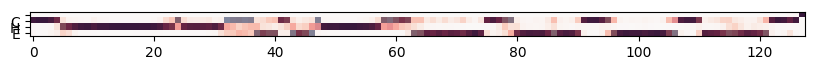

---
Input: SRGTQTE
Target: CEEEECC
Result: CCCCCCC


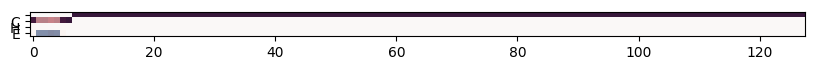

---
Input: MKEEKRSSTGFLVKQRAFLKLYMITMTEQERLYGLKLLKVLQSEFKEIGFKPNHTEVYRSLHELLDDGILKQIKVKKEGAKLQEVVLYQFKDYEAAKLYKKQLKVELDRCKKLIEKALSDNF
Target: CCCCCCCCCCCCCCHHHHHHHHHHHHHHCCCEECCCCHHHHHHHHCCCCCCCCHHHHHHHHHHHHHCCCEEEEECCCCCCCCCCCEEEEECCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHC
Result: CCCCCCCCCCCHHHHHHHHHHHHHHHHHHHHCCCHHHHHHHHHHHHHHCCCCHHHHHHHHHHHHHCHCCCEEEEECCCCCCCCCCEEEECHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCC


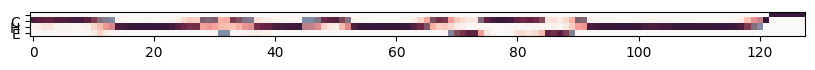

testing
---
Input: MKRQKRDRLERAHQRGYQAGIAGRSKEMCPYQTLNQRSQWLGGWREAMADRVVMAHHHHHH
Target: CCCCCHHHHHHHHHHHHHHHHCCCCCCCCCCCCHHHHHHHHHHHHHHHHHCCCCCCCCCCC
Result: CCCCCHHHHHHHHHHHHHHHHHCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCCCCC


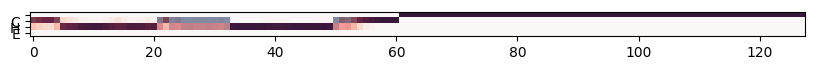

---
Input: YCQKWMWTCDEERKCCEGLVCRLWCKRIINM
Target: CCCCCCCECCCCCCCCCCCECCCECECCCCC
Result: CCCCCCECCCCCCCCCCCCCCCCEEEEEECC


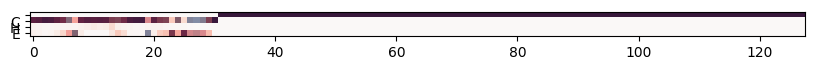

---
Input: TEFSEEQKRTLDLLFLFDRRMTEERRRWLSQRLGLNEEQIERWFRRKEQQI
Target: CCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCHHHHHHHHHCCCCCC
Result: CCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCHHHHHHHHHHHHHHCCC


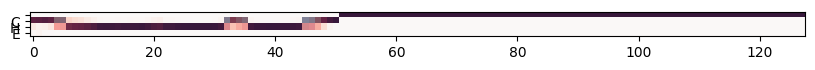

In [25]:
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

def plot_results(x, y, y_):
    print("---")
    print("Input: " + str(x))
    print("Target: " + str(onehot_to_seq(y, revsere_decoder_index).upper()))
    print("Result: " + str(onehot_to_seq(y_, revsere_decoder_index).upper()))
    fig = plt.figure(figsize=(10,2))
    plt.imshow(y.T, cmap='Blues')
    plt.imshow(y_.T, cmap='Reds', alpha=.5)
    plt.yticks(range(4), [' '] + [revsere_decoder_index[i+1].upper() for i in range(3)])
    plt.show()
    
revsere_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()}
revsere_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()}

N=3
y_train_pred = model.predict(X_train[:N])
y_test_pred = model.predict(X_test[:N])
print('training')
for i in range(N):
    plot_results(seq_train[i], y_train[i], y_train_pred[i])
print('testing')
for i in range(N):
    plot_results(seq_test[i], y_test[i], y_test_pred[i])